In [ ]:
!kaggle datasets download -d brendanartley/cartoon-faces-googles-cartoon-set

Dataset URL: https://www.kaggle.com/datasets/brendanartley/cartoon-faces-googles-cartoon-set
License(s): Attribution 4.0 International (CC BY 4.0)
100% 2.33G/2.34G [00:40<00:00, 92.2MB/s]
100% 2.34G/2.34G [00:40<00:00, 61.7MB/s]


In [ ]:
!kaggle datasets download -d arbazkhan971/cuhk-face-sketch-database-cufs

Dataset URL: https://www.kaggle.com/datasets/arbazkhan971/cuhk-face-sketch-database-cufs
License(s): copyright-authors
 99% 112M/113M [00:02<00:00, 84.1MB/s]
100% 113M/113M [00:02<00:00, 54.7MB/s]


In [ ]:
!unzip /content/cartoon-faces-googles-cartoon-set.zip


In [ ]:
!unzip /content/cuhk-face-sketch-database-cufs.zip


In [ ]:
import numpy as np

import torchvision.transforms as transforms
from torchvision.utils import make_grid

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch

import os

In [ ]:
class ConvolutionalBlock(nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        is_downsampling: bool = True,
        add_activation: bool = True,
        **kwargs
    ):
        super().__init__()
        if is_downsampling:
            self.conv = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, padding_mode="reflect", **kwargs),
                nn.InstanceNorm2d(out_channels),
                nn.ReLU(inplace=True) if add_activation else nn.Identity(),
            )
        else:
            self.conv = nn.Sequential(
                nn.ConvTranspose2d(in_channels, out_channels, **kwargs),
                nn.InstanceNorm2d(out_channels),
                nn.ReLU(inplace=True) if add_activation else nn.Identity(),
            )

    def forward(self, x):
        return self.conv(x)

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()

        self.block = nn.Sequential(
            ConvolutionalBlock(channels, channels, add_activation=True, kernel_size=3, padding=1),
            ConvolutionalBlock(channels, channels, add_activation=False, kernel_size=3, padding=1),
        )

    def forward(self, x):
        return x + self.block(x)

In [ ]:
class LocalSelfAttention(nn.Module):
    def __init__(self, input_dim, patch_size):
        super(LocalSelfAttention, self).__init__()
        self.input_dim = input_dim
        self.patch_size = patch_size
        self.query = nn.Linear(input_dim, input_dim)
        self.key = nn.Linear(input_dim, input_dim)
        self.value = nn.Linear(input_dim, input_dim)
        self.softmax = nn.Softmax(dim=-1)  # Apply softmax on the last dimension

    def forward(self, x):
        batch_size, channels, height, width = x.shape
        assert height % self.patch_size == 0 and width % self.patch_size == 0, \
            "Height and width must be divisible by the patch size."

        # Split the image into non-overlapping patches
        patches = x.unfold(2, self.patch_size, self.patch_size).unfold(3, self.patch_size, self.patch_size)
        patches = patches.contiguous().view(batch_size, channels, -1, self.patch_size * self.patch_size)
        patches = patches.permute(0, 2, 3, 1)  # Shape: (batch_size, num_patches, patch_area, channels)

        # Apply self-attention within each patch
        queries = self.query(patches)
        keys = self.key(patches)
        values = self.value(patches)

        # Compute the attention scores
        scores = torch.einsum('bqpd,bkpd->bqkp', queries, keys) / (self.input_dim ** 0.5)

        # Apply softmax to get the attention weights
        attention = self.softmax(scores)

        # Compute the weighted sum of values
        weighted = torch.einsum('bqkp,bkpd->bqpd', attention, values)

        # Reshape back to the original image structure
        weighted = weighted.permute(0, 3, 1, 2).contiguous().view(batch_size, channels, height, width)

        return weighted + x  # Add residual connection

In [ ]:

class Generator(nn.Module):
    def __init__(
        self, img_channels: int, num_features: int = 64, num_residuals: int = 9
    ):

        super().__init__()
        self.initial_layer = nn.Sequential(
            nn.Conv2d(
                img_channels,
                num_features,
                kernel_size=7,
                stride=1,
                padding=3,
                padding_mode="reflect",
            ),
            nn.ReLU(inplace=True),
            LocalSelfAttention(num_features, 32)
        )

        self.downsampling_layers = nn.ModuleList(
            [
                ConvolutionalBlock(
                    num_features,
                    num_features * 2,
                    is_downsampling=True,
                    kernel_size=3,
                    stride=2,
                    padding=1,
                ),
                ConvolutionalBlock(
                    num_features * 2,
                    num_features * 4,
                    is_downsampling=True,
                    kernel_size=3,
                    stride=2,
                    padding=1,
                ),
            ]
        )

        self.residual_layers = nn.Sequential(
            *[ResidualBlock(num_features * 4) for _ in range(num_residuals)]
        )

        self.upsampling_layers = nn.ModuleList(
            [
                ConvolutionalBlock(
                    num_features * 4,
                    num_features * 2,
                    is_downsampling=False,
                    kernel_size=3,
                    stride=2,
                    padding=1,
                    output_padding=1,
                ),
                ConvolutionalBlock(
                    num_features * 2,
                    num_features * 1,
                    is_downsampling=False,
                    kernel_size=3,
                    stride=2,
                    padding=1,
                    output_padding=1,
                ),
            ]
        )

        self.last_layer = nn.Sequential(
            LocalSelfAttention(num_features, 32),
            nn.Conv2d(
              num_features * 1,
              img_channels,
              kernel_size=7,
              stride=1,
              padding=3,
              padding_mode="reflect",
              ),
        )

    def forward(self, x):
        x = self.initial_layer(x)
        for layer in self.downsampling_layers:
            x = layer(x)
        x = self.residual_layers(x)
        for layer in self.upsampling_layers:
            x = layer(x)
        return torch.tanh(self.last_layer(x))


In [ ]:
class ConvInstanceNormLeakyReLUBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, stride: int):

        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size=4,
                stride=stride,
                padding=1,
                bias=True,
                padding_mode="reflect",
            ),
            nn.InstanceNorm2d(out_channels),
            nn.LeakyReLU(0.2, inplace=True),
        )

    def forward(self, x):
        return self.conv(x)


In [ ]:
class Discriminator(nn.Module):
    def __init__(self, in_channels=3, features=[64, 128, 256, 512]):

        super().__init__()
        # self.output_shape = (1, 30, 30)
        self.initial_layer = nn.Sequential(
            nn.Conv2d(
                in_channels,
                features[0],
                kernel_size=4,
                stride=2,
                padding=1,
                padding_mode="reflect",
            ),
            nn.LeakyReLU(0.2, inplace=True),
        )

        layers = []
        in_channels = features[0]
        for feature in features[1:]:
            layers.append(
                ConvInstanceNormLeakyReLUBlock(
                    in_channels,
                    feature,
                    stride=1 if feature == features[-1] else 2,
                )
            )
            in_channels = feature

        # After the last layer, we apply a convolution to produce a 1-dimensional output
        layers.append(
            nn.Conv2d(
                in_channels,
                1,
                kernel_size=4,
                stride=1,
                padding=1,
                padding_mode="reflect",
            )
        )
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = self.initial_layer(x)

        # feed the model output into a sigmoid function to make a 1/0 label
        return torch.sigmoid(self.model(x))

In [ ]:
# data (path)
root = '/content'
import os
import glob
from torch.utils.data import Dataset
import random
from PIL import Image


def to_rgb(image):
    rgb_image = Image.new("RGB", image.size)
    rgb_image.paste(image)
    return rgb_image

class ImageDataset(Dataset):
    def __init__(self, root, transforms_=None, unaligned=False, mode='train'):
        self.transform = transforms.Compose(transforms_)
        self.unaligned = unaligned
        self.mode = mode
        if self.mode == 'train':
            self.files_A = sorted(glob.glob(os.path.join(root+'/photos')+'/*.*'))[100:]
            self.files_B = sorted(glob.glob(os.path.join(root+'/cartoonset100k_jpg/1')+'/*.*'))[100:]
        elif self.mode == 'test':
            self.files_A = sorted(glob.glob(os.path.join(root+'/photos')+'/*.*'))[100:]
            self.files_B = sorted(glob.glob(os.path.join(root+'//cartoonset100k_jpg/1')+'/*.*'))[100:]

    def  __getitem__(self, index):
        image_A = Image.open(self.files_A[index % len(self.files_A)])

        if self.unaligned:
            image_B = Image.open(self.files_B[np.random.randint(0, len(self.files_B)-1)])
        else:
            image_B = Image.open(self.files_B[index % len(self.files_B)])
        if image_A.mode != 'RGB':
            image_A = to_rgb(image_A)
        if image_B.mode != 'RGB':
            image_B = to_rgb(image_B)

        item_A = self.transform(image_A)
        item_B = self.transform(image_B)
        return {'A':item_A, 'B':item_B}

    def __len__(self):
        return max(len(self.files_A), len(self.files_B))

In [ ]:
import torchvision.transforms as transforms

# data (img)
img_height = 256
img_width = 256
channels = 3

input_shape = (channels, img_height, img_width) # (3,256,256)


transforms_ = [
    transforms.Resize(int(img_height*1.12), Image.BICUBIC),
    transforms.RandomCrop((img_height, img_width)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
]

In [ ]:
dataloader = DataLoader(
    ImageDataset(root, transforms_=transforms_, unaligned=True),
    batch_size=1, # 1
    shuffle=True,
    num_workers=0 # 3
)

val_dataloader = DataLoader(
    ImageDataset(root, transforms_=transforms_, unaligned=True, mode='test'),
    batch_size=5,
    shuffle=True,
    num_workers=0
)

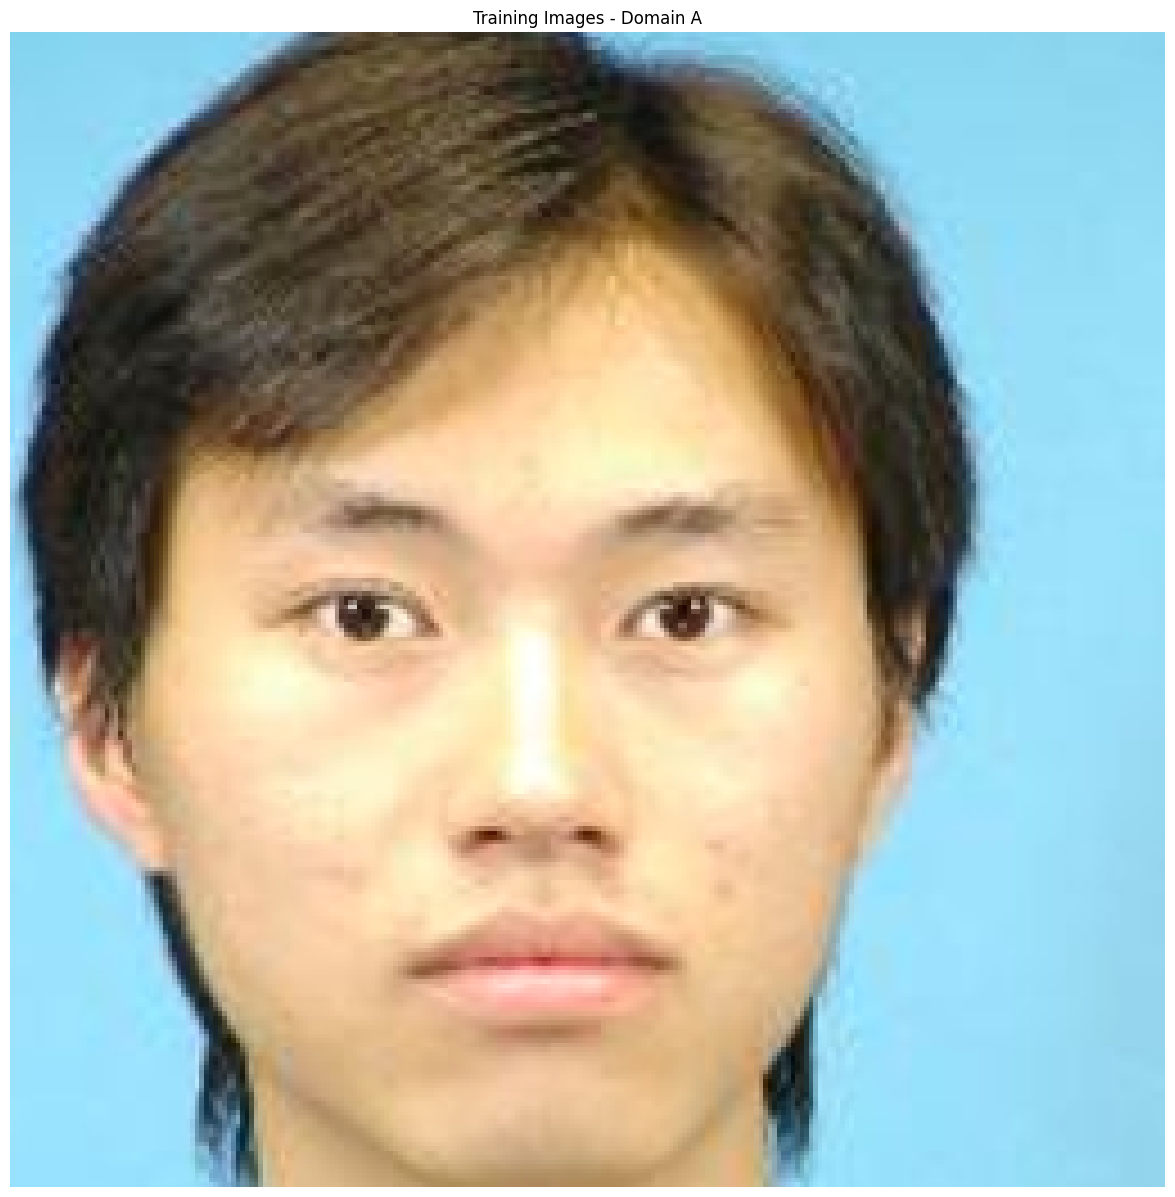

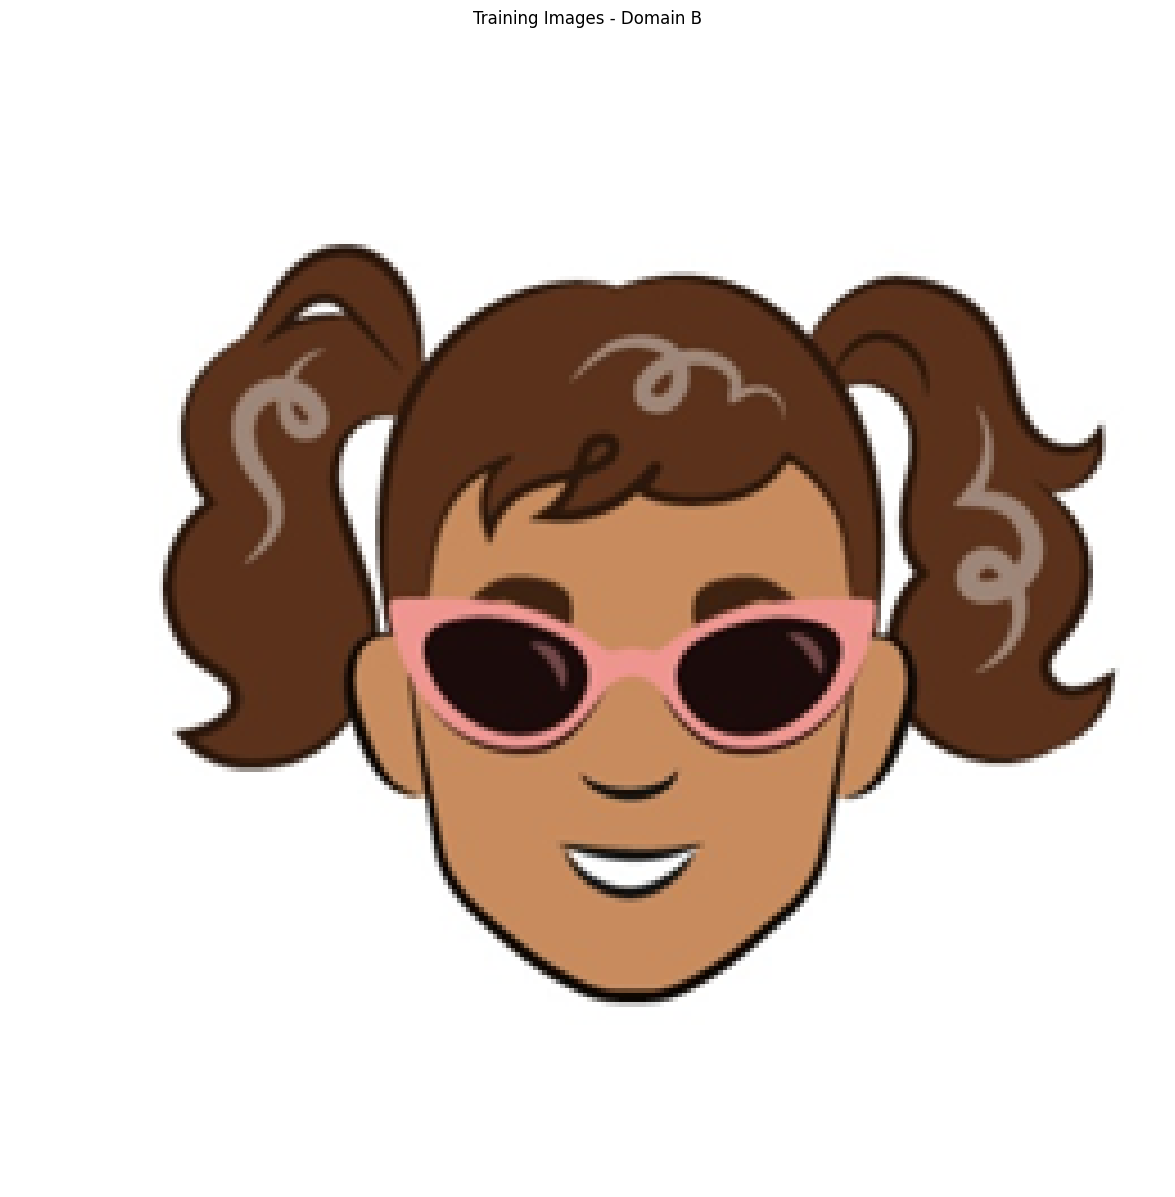

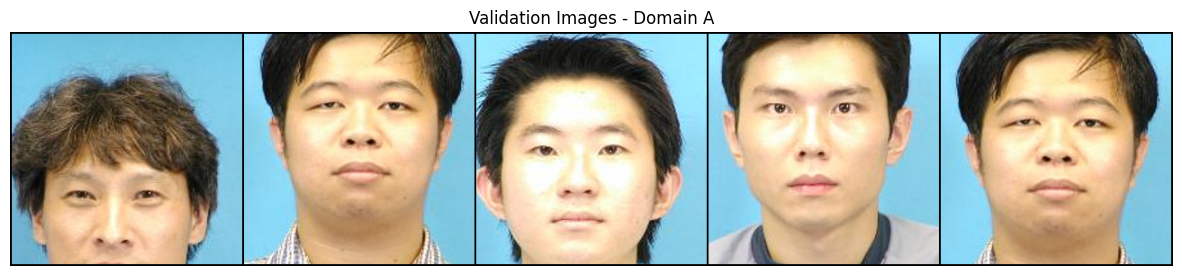

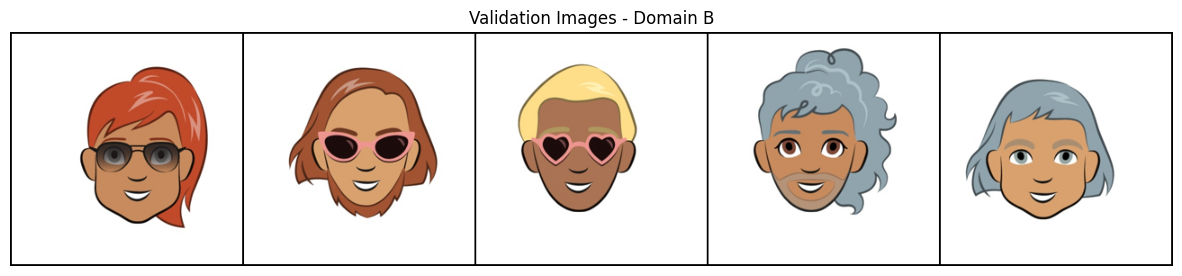

In [ ]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

# Function to denormalize the image
def denormalize(tensor):
    return (tensor + 1) / 2

# Function to display a batch of images
def show_batch(batch, title):
    imgs = denormalize(batch)
    grid = make_grid(imgs, nrow=5)
    plt.figure(figsize=(15, 15))
    plt.title(title)
    plt.imshow(grid.permute(1, 2, 0))
    plt.axis('off')
    plt.show()

# Get a batch from the training dataloader
train_batch = next(iter(dataloader))

# Display images from domain A
show_batch(train_batch['A'], 'Training Images - Domain A')

# Display images from domain B
show_batch(train_batch['B'], 'Training Images - Domain B')

# Get a batch from the validation dataloader
val_batch = next(iter(val_dataloader))

# Display validation images from domain A
show_batch(val_batch['A'], 'Validation Images - Domain A')

# Display validation images from domain B
show_batch(val_batch['B'], 'Validation Images - Domain B')

In [ ]:
import matplotlib.pyplot as plt

cuda = torch.cuda.is_available()
Tensor = torch.cuda.FloatTensor if cuda else torch.Tensor

def sample_images():
    """show a generated sample from the test set"""
    imgs = next(iter(val_dataloader))
    G_AB.eval()
    G_BA.eval()
    real_A = imgs['A'].type(Tensor) # A : monet
    fake_B = G_AB(real_A).detach()
    real_B = imgs['B'].type(Tensor) # B : photo
    fake_A = G_BA(real_B).detach()
    # Arange images along x-axis
    real_A = make_grid(real_A, nrow=5, normalize=True)
    fake_B = make_grid(fake_B, nrow=5, normalize=True)
    real_B = make_grid(real_B, nrow=5, normalize=True)
    fake_A = make_grid(fake_A, nrow=5, normalize=True)
    # Arange images along y-axis
    image_grid = torch.cat((real_A, fake_B, real_B, fake_A), 1)
    plt.imshow(image_grid.cpu().permute(1,2,0))
    plt.title('Real A vs Fake B | Real B vs Fake A')
    plt.axis('off')
    plt.show()

In [ ]:
criterion_GAN = torch.nn.MSELoss()
criterion_cycle = torch.nn.L1Loss()
criterion_identity = torch.nn.L1Loss()

In [ ]:
n_residual_blocks = 9 # suggested default, number of residual blocks in generator

G_AB = Generator(input_shape[0])
G_BA = Generator(input_shape[0])
D_A = Discriminator()
D_B = Discriminator()

In [ ]:
# cuda = torch.cuda.is_available()
print(f'cuda: {cuda}')

if cuda:
    G_AB = G_AB.cuda()
    G_BA = G_BA.cuda()
    D_A = D_A.cuda()
    D_B = D_B.cuda()

    criterion_GAN.cuda()
    criterion_cycle.cuda()
    criterion_identity.cuda()

    print('using GPU')
else:
    print('using CPU')

cuda: True
using GPU


In [ ]:
pytorch_total_params = sum(p.numel() for p in G_AB.parameters())
total = pytorch_total_params
print(pytorch_total_params)
pytorch_total_params = sum(p.numel() for p in G_BA.parameters())
total += pytorch_total_params
print(pytorch_total_params)
pytorch_total_params = sum(p.numel() for p in D_A.parameters())
total += pytorch_total_params
print(pytorch_total_params)
pytorch_total_params = sum(p.numel() for p in D_B.parameters())
total += pytorch_total_params
print(pytorch_total_params)
print(total)

11403139
11403139
2764737
2764737
28335752


In [ ]:
import itertools
lr = 0.0001
b1 = 0.5
b2 = 0.999

optimizer_G = torch.optim.Adam(
    itertools.chain(G_AB.parameters(), G_BA.parameters()), lr=lr, betas=(b1,b2)
)

optimizer_D_A = torch.optim.Adam(
    D_A.parameters(), lr=lr, betas=(b1,b2)
)
optimizer_D_B = torch.optim.Adam(
    D_B.parameters(), lr=lr, betas=(b1,b2)
)

In [ ]:
# Learning Rate Scheduler Setting
class LambdaLR:
    def __init__(self, n_epochs, offset, decay_start_epoch):
        assert (n_epochs - decay_start_epoch) > 0, "Decay must start before the training session ends!"
        self.n_epochs = n_epochs
        self.offset = offset
        self.decay_start_epoch = decay_start_epoch

    def step(self, epoch):
        return 1.0 - max(0, epoch+self.offset - self.decay_start_epoch)/(self.n_epochs - self.decay_start_epoch)

In [ ]:
n_epochs = 5
epoch = 0
decay_epoch = 0


lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(
    optimizer_G,
    lr_lambda=LambdaLR(n_epochs, epoch, decay_epoch).step
)

lr_scheduler_D_A = torch.optim.lr_scheduler.LambdaLR(
    optimizer_D_A,
    lr_lambda=LambdaLR(n_epochs, epoch, decay_epoch).step
)
lr_scheduler_D_B = torch.optim.lr_scheduler.LambdaLR(
    optimizer_D_B,
    lr_lambda=LambdaLR(n_epochs, epoch, decay_epoch).step
)

In [ ]:
class ImageBuffer:
    def __init__(self, buffer_size=50):
        self.buffer_size = buffer_size
        self.buffer = []

    def add_and_sample(self, images):
        sampled_images = []
        for img in images:
            if len(self.buffer) < self.buffer_size:
                self.buffer.append(img)
                sampled_images.append(img)
            else:
                # Randomly decide whether to use a new image or a buffered one
                if np.random.uniform(0, 1) > 0.5:
                    idx = np.random.randint(0, len(self.buffer))
                    sampled_images.append(self.buffer[idx].clone())
                    self.buffer[idx] = img  # Replace with new image
                else:
                    sampled_images.append(img)
        return sampled_images


In [ ]:
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import warnings

  0%|          | 0/9900 [00:00<?, ?it/s]

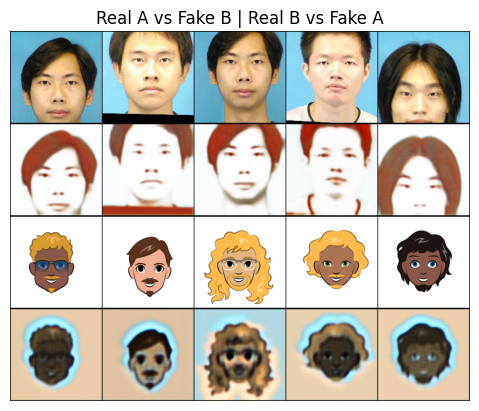

[Epoch 1/5] [Batch 50/9900] [D loss : 0.185101] [G loss : 2.430986 - (adv : 0.350684, cycle : 0.140931, identity : 0.134198)]


KeyboardInterrupt: 

In [ ]:

for epoch in range(epoch, n_epochs):
  """
  Input: (batch_size, 3, 256, 256)
  After 4 convolutional layers (stride 2): (batch_size, 512, 16, 16)
  Final convolutional layer: (batch_size, 1, 30, 30)

  """

  fake_A_buffer = ImageBuffer(buffer_size=50)  # For fake images generated by G_BA
  fake_B_buffer = ImageBuffer(buffer_size=50)  # For fake images generated by G_AB


  for i, batch in enumerate(tqdm(dataloader)):

      # Set model input
      real_A = batch['A'].type(Tensor)
      real_B = batch['B'].type(Tensor)

      # Adversarial ground truths
      valid = Tensor(np.ones((real_A.size(0), *(1, 30, 30)))) # requires_grad = False. Default.
      fake = Tensor(np.zeros((real_A.size(0), *(1, 30, 30)))) # requires_grad = False. Default.

      # Train Generators
      # -----------------
      G_AB.train() # train mode
      G_BA.train() # train mode

      optimizer_G.zero_grad() # Integrated optimizer(G_AB, G_BA)

      # Identity Loss
      loss_id_A = criterion_identity(G_BA(real_A), real_A) # If you put A into a generator that creates A with B,
      loss_id_B = criterion_identity(G_AB(real_B), real_B) # then of course A must come out as it is.
                                                            # Taking this into consideration, add an identity loss that simply compares 'A and A' (or 'B and B').
      loss_identity = (loss_id_A + loss_id_B)/2

      # GAN Loss
      fake_B = G_AB(real_A) # fake_B is fake-photo that generated by real monet-drawing
      loss_GAN_AB = criterion_GAN(D_B(fake_B), valid) # tricking the 'fake-B' into 'real-B'
      fake_A = G_BA(real_B)
      loss_GAN_BA = criterion_GAN(D_A(fake_A), valid) # tricking the 'fake-A' into 'real-A'

      loss_GAN = (loss_GAN_AB + loss_GAN_BA)/2

      # Cycle Loss
      recov_A = G_BA(fake_B) # recov_A is fake-monet-drawing that generated by fake-photo
      loss_cycle_A = criterion_cycle(recov_A, real_A) # Reduces the difference between the restored image and the real image
      recov_B = G_AB(fake_A)
      loss_cycle_B = criterion_cycle(recov_B, real_B)

      loss_cycle = (loss_cycle_A + loss_cycle_B)/2

      # ------> Total Loss
      loss_G = loss_GAN + (10.0*loss_cycle) + (5.0*loss_identity) # multiply suggested weight(default cycle loss weight : 10, default identity loss weight : 5)

      loss_G.backward()
      optimizer_G.step()

      # -----------------
      # Train Discriminator A
      # -----------------
      optimizer_D_A.zero_grad()


      # Get buffered fake_A images
      fake_A_buffered = torch.stack(fake_A_buffer.add_and_sample(fake_A))

      loss_real = criterion_GAN(D_A(real_A), valid) # train to discriminate real images as real
      loss_fake = criterion_GAN(D_A(fake_A_buffered.detach()), fake) # train to discriminate fake images as fake

      loss_D_A = (loss_real + loss_fake)/2

      loss_D_A.backward()
      optimizer_D_A.step()

      # -----------------
      # Train Discriminator B
      # -----------------
      optimizer_D_B.zero_grad()

      # Get buffered fake_B images
      fake_B_buffered = torch.stack(fake_B_buffer.add_and_sample(fake_B))

      loss_real = criterion_GAN(D_B(real_B), valid) # train to discriminate real images as real
      loss_fake = criterion_GAN(D_B(fake_B_buffered.detach()), fake) # train to discriminate fake images as fake

      loss_D_B = (loss_real + loss_fake)/2

      loss_D_B.backward()
      optimizer_D_B.step()

      #------> Total Loss
      loss_D = (loss_D_A + loss_D_B)/2


      # -----------------
      # Show Progress
      # -----------------
      if (i+1) % 50 == 0:
          sample_images()
          print('[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]'
                  %(epoch+1,n_epochs,       # [Epoch -]
                    i+1,len(dataloader),   # [Batch -]
                    loss_D.item(),       # [D loss -]
                    loss_G.item(),       # [G loss -]
                    loss_GAN.item(),     # [adv -]
                    loss_cycle.item(),   # [cycle -]
                    loss_identity.item(),# [identity -]
                    ))
  lr_scheduler_G.step()
  lr_scheduler_D_A.step()
  lr_scheduler_D_B.step()

In [ ]:
sample_images()